# <p style="text-align: center;"> CS6476 | Computer Vision ps2 </p>
<p style="text-align: center;">Alexis Durocher - MSCS student at Georgia Tech</p>
<p style="text-align: center;">Spring 2018</p>


In [1]:
import cv2

from scipy import ndimage
from scipy import misc
import numpy as np
import math as mtugh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import peak_local_max
from skimage import io


### 1. Basic Stereo Algorithm

In [2]:
input1_left = cv2.imread("./Data/leftTest.png", 0)
input1_right = cv2.imread("./Data/rightTest.png", 0)

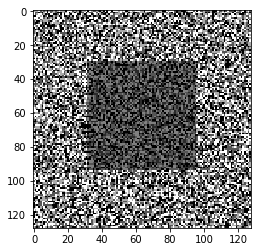

In [3]:
plt.imshow(input1_left, cmap="gray")
plt.show()

#### a. SSD

In [37]:
def compute_SSD(window0, window1):
    # cast to avod
    window_sub = window0 - window1
    window_ssd = np.square(window_sub)
    sum_ssd = np.sum(window_ssd)

    return sum_ssd

def compute_NORMA_CORR(row_dest, template):
    # cast to avoid
    res = cv2.matchTemplate(row_dest, template, cv2.TM_CCOEFF_NORMED)
    max_sim = np.argmax(res)
    return max_sim

def compute_norm_corr_on_dest_row(r0, c0, window0, img_dest, window_size = 10, l_to_r=True,
                                 max_offset = 110, min_offset = 30):
    height_dest, width_dest = img_dest.shape
    best_offset = 0
    min_disp = 100000000

    max_offset = max_offset
    min_offset = min_offset
    if l_to_r :
        tmp = max_offset
        max_offset = min_offset
        min_offset = tmp
    max_offset = int(min(c0 + max_offset + window_size / 2, width_dest -1))
    min_offset = int(max(c0 - min_offset - window_size /2, 0))

    top_row = int(max(r0 - window_size / 2, 0))
    down_row = int(min(r0 + window_size / 2, height_dest - 1))


    row_dest = np.array(img_dest[top_row: down_row, min_offset: max_offset] , dtype=np.float32)
    best_similarity = compute_NORMA_CORR(row_dest, window0)
    best_similarity = min_offset + best_similarity # back in col coordinates
    best_shift =  best_similarity - c0 + window_size/2

    return int(best_shift)

def compute_min_disp_on_dest_row(r0, c0, window0, img_dest, window_size=10, l_to_r=False,
                                max_offset = 110, min_offset = 30):
    height_dest, width_dest = img_dest.shape
    max_offset = max_offset
    min_offset = -min_offset
    best_offset = 0
    min_disp = 100000000

    for offset in range(min_offset, max_offset):
        if l_to_r:
            offset = -offset
        c = c0 + offset

        le_col = int(c - window_size / 2)
        ri_col = int(c + window_size / 2)
        if ((0 <= le_col) & (ri_col < width_dest)):
            top_row = int(r0 - window_size / 2)
            down_row = int(r0 + window_size / 2)
            window1 = np.array(img_dest[top_row: down_row, le_col: ri_col], dtype='int32')
            disp = compute_SSD(window0, window1)
            # plt.title("Right input1 computed from Left input1")
            plt.show()
            if disp < min_disp:
                min_disp = disp
                best_offset = offset
    # return best match (lowest ssd) 
    return best_offset


def basic_stereo_algo(img_ori, img_dest, verbose=False, l_to_r=False, norma_corr = False,
                     window_size = 16, max_offset = 110, min_offset = 30):
    height_ori, width_ori = img_ori.shape
    D = np.zeros(img_ori.shape)
    window_size = window_size
    # for each origin pixels
    for r in range(0, height_ori):
        if (verbose):
            print("--- " + str((r + 1) * 100 / height_ori) + " %")
        top_row = int(r - window_size / 2)
        down_row = int(r + window_size / 2)
        if ((0 <= top_row) & (down_row < height_ori)):
            for c in range(0, width_ori):
                le_col = int(c - window_size / 2)
                ri_col = int(c + window_size / 2)
                if ((0 <= le_col) & (ri_col < width_ori)):
                    # 1. fix an origin window centered in r, c
                    window_ori = np.array(
                        img_ori[top_row: down_row, le_col: ri_col], dtype=np.float32)
                    # 2 .fix a destination window centered in in r, c
                    # run the window on the horizontal row r of dest
                    if norma_corr :
                        min_ssd = compute_norm_corr_on_dest_row(r, 
                                                                c, 
                                                                window_ori, 
                                                                img_dest, 
                                                                window_size, 
                                                                l_to_r=l_to_r,
                                                                max_offset = max_offset,
                                                                min_offset = min_offset)
                    else :
                        min_ssd = compute_min_disp_on_dest_row(r,
                                                               c,
                                                               window_ori,
                                                               img_dest,
                                                               window_size,
                                                               l_to_r=l_to_r,
                                                               max_offset = max_offset,
                                                               min_offset = min_offset)
                    D[r, c] = min_ssd

    return D


def normalize_disparity(x):
    height, width = x.shape
    x_temp = np.zeros(x.shape)
    for i in range(0, height):
        for j in range(0, width):
            x_temp[i, j] = max(0, min(255, x[i, j]))
    return x_temp

In [5]:
D1_l_to_r = basic_stereo_algo(input1_left, input1_right, l_to_r = True)

In [6]:
D1_r_to_l = basic_stereo_algo(input1_right, input1_left, l_to_r = False)

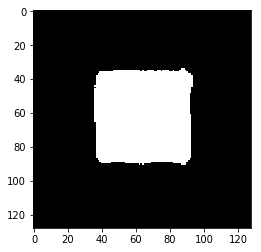

In [92]:
D1_l_to_r_norm = np.absolute(D1_l_to_r)
D1_r_to_l_norm = np.absolute(D1_r_to_l)
plt.imshow(D1_l_to_r_norm, cmap ='gray')
plt.show()

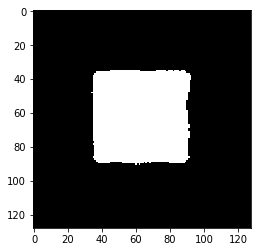

In [93]:
plt.imshow(D1_r_to_l_norm, cmap ='gray')
plt.show()

misc.imsave('./output/ps2-1-a-1.png', D1_l_to_r_norm)
misc.imsave('./output/ps2-1-a-2.png', D1_r_to_l_norm)

<u> Interpretation </u>

On both left and right disparity picture, the central square does clearly appears. The borders of this shape are not completely straight. In the SSD method, it's the pixels intensity and only this which is taken into account as a disparity metric. Hence the SSD would choose a window with a closer (sumf of diff of) intensity levels rather than a window which actually corresponds to the template. In case of very close intensity levels, which happens on the border of the square, this can leads to inaccuracy.

In [8]:
def compute_translation(img_ori, D) :

    img_dest_synt = np.zeros(img_ori.shape)
    height, width = img_dest_synt.shape

    for i in range(0, height):
        for j in range(0, width):
            img_dest_synt[i,j] = img_ori[int(i + D[i,j]), j]
    return img_dest_synt

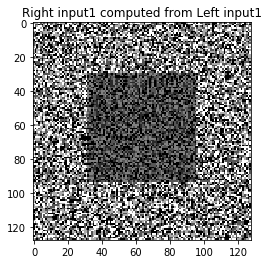

In [89]:
synt_input1_right = compute_translation(input1_left, D1_l_to_r)
synt_input1_left = compute_translation(input1_right, D1_r_to_l)

plt.imshow(synt_input1_right, cmap= 'gray')
plt.title("Right input1 computed from Left input1")
plt.show()

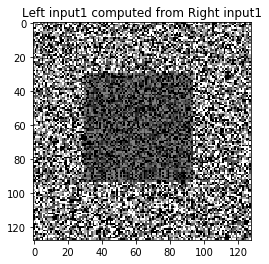

In [91]:
plt.imshow(synt_input1_left, cmap= 'gray')
plt.title("Left input1 computed from Right input1")
plt.show()

### 2. Real images

In [10]:
input21_left = cv2.imread("./Data/proj2-pair1-L.png", 0)
input21_right = cv2.imread("./Data/proj2-pair1-R.png", 0)

Note that we will choose the min offset and max offset by approximating the max and min offset between the original pictures. Thus, we make sure that our template matcher will compare the template of one picture to its corresponding part on the other picture. It is an important detail since some objects are much more shifted than others depending on their position with respect to the camera. Hence, it is a trade off between choosing a big enough offset to detect the shift and taking the risk of reducing the accuracy on the disparity of 'non mobile' background objects.

#### a. SSD

In [11]:
D2_l_to_r = basic_stereo_algo(input21_left, input21_right, verbose = False, l_to_r= True)

In [12]:
D2_r_to_l = basic_stereo_algo(input21_right, input21_left, verbose = False, l_to_r= False)

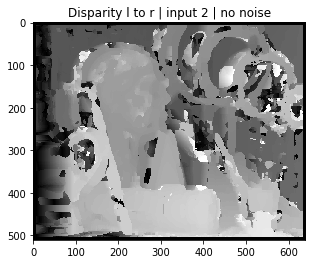

In [87]:
plt.imshow(np.absolute(D2_l_to_r), cmap = 'gray')
plt.title("Disparity l to r | input 2 | no noise")
plt.show()

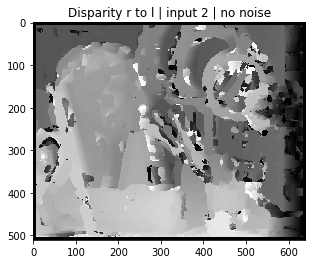

In [88]:
plt.imshow(np.absolute(D2_r_to_l), cmap = 'gray')
plt.title("Disparity r to l | input 2 | no noise")
plt.show()

misc.imsave('./output/ps2-2-a-1.png', np.absolute(D2_l_to_r))
misc.imsave('./output/ps2-2-a-2.png', np.absolute(D2_r_to_l))

#### Compare with ground truth

In [14]:
input21_Disp_left = cv2.imread('./Data/proj2-pair1-Disp-L.png')
input21_Disp_right = cv2.imread('./Data/proj2-pair1-Disp-R.png')

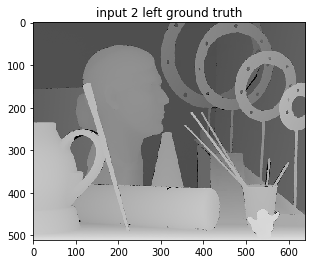

In [15]:
plt.imshow(input21_Disp_left, cmap ='gray')
plt.title("input 2 left ground truth")
plt.show()

<u> Interpretation </u>

On the ground truth, we clearly see objects' disparity from one picture to an other. In particular, objects in front plane have a higher dispartity (they are more shifted from one picture to an other).

SSD seems to work realtively nicely on non-pertubated picture. However, real picture are usually taken with noise or different luminosity. We will now see the effect of such perturbation on the SSD accuracy.

### 3 Effect of pertubation

#### a . Adding gaussian Noise

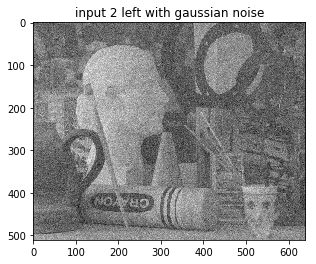

In [16]:
def noisy(image):
    mu, sigma, n = np.mean(image), 30, image.shape[0]*image.shape[1]
    # adding gaussian noise
    gaussian_noise = np.random.normal(mu, sigma, n).reshape(image.shape[0],image.shape[1])
    return image + gaussian_noise


gaussian_input21_L = noisy(input21_left)
gaussian_input21_R = noisy(input21_right)
plt.imshow(gaussian_input21_L, cmap = 'gray')
plt.title("input 2 left with gaussian noise")
plt.show()

In [17]:
D2_l_to_r_gaussian = basic_stereo_algo(gaussian_input21_L, input21_right, 
                                       verbose = False, l_to_r= True)

In [18]:
D2_l_to_r_gaussian_both = basic_stereo_algo(gaussian_input21_L, gaussian_input21_R,
                                            verbose = False, l_to_r= True)

In [19]:
D2_r_to_l_gaussian_both = basic_stereo_algo(gaussian_input21_R, gaussian_input21_L,
                                            verbose = False, l_to_r= False)

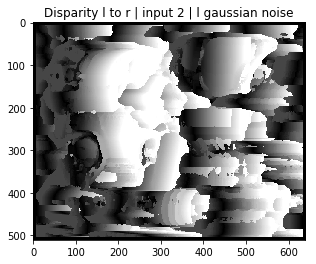

In [20]:
plt.imshow(np.absolute(D2_l_to_r_gaussian), cmap = 'gray')
plt.title("Disparity l to r | input 2 | l gaussian noise")
plt.show()

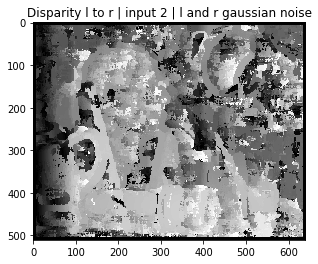

In [21]:
plt.imshow(np.absolute(D2_l_to_r_gaussian_both), cmap = 'gray')
plt.title("Disparity l to r | input 2 | l and r gaussian noise")
plt.show()

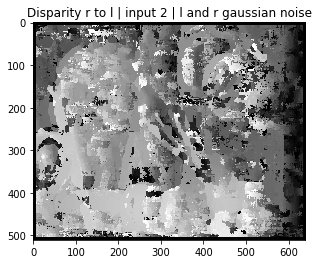

In [22]:
plt.imshow(np.absolute(D2_r_to_l_gaussian_both), cmap = 'gray')
plt.title("Disparity r to l | input 2 | l and r gaussian noise")
plt.show()

In [23]:
misc.imsave('./output/ps2-3-a-1.png', np.absolute(D2_l_to_r_gaussian_both))
misc.imsave('./output/ps2-3-a-2.png', np.absolute(D2_r_to_l_gaussian_both))

<u> Interpretation </u>

The SSD is clearly not robust enough to gaussian noise. The resulting dispartity pictures are much less accurate than ground truth, in terms of disparity. This could be explained because of the random caracteristic of the Gaussian Noise. Adding a gaussian noise has somehow 'blurred' the difference of intensity between windows. Thus, the SSD faces troubles with template/window matching.

This noisy effect is even increased when we try to match two pictures with gaussian noise. This makes sense due to a bigger randomness in pixel intensities.

#### b. Increasing the contrast

In [24]:
def change_contrast(img, factor):
    img_bis = np.array(img, dtype = 'int32')
    contrasted = img_bis * factor
    contrasted[contrasted >= 255] = 255
    return contrasted

In [25]:
input21_left_contrast = change_contrast(input21_left, 1.1)
input21_right_contrast = change_contrast(input21_right, 1.1)

In [26]:
D2_l_to_r_contrast = basic_stereo_algo(input21_left_contrast, 
                                       input21_right, 
                                       verbose = False, l_to_r= True)

In [27]:
D2_l_to_r_contrast_both = basic_stereo_algo(input21_left_contrast, 
                                            input21_right_contrast, 
                                            verbose = False, l_to_r= True)

In [28]:
D2_r_to_l_contrast_both = basic_stereo_algo(input21_right_contrast, 
                                            input21_left_contrast, 
                                            verbose = False, l_to_r= False)

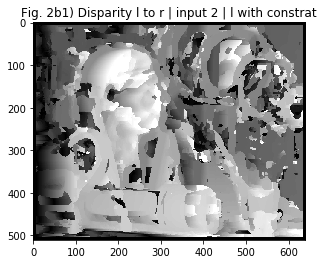

In [29]:
plt.imshow(np.absolute(D2_l_to_r_contrast), cmap = 'gray')
plt.title("Fig. 2b1) Disparity l to r | input 2 | l with constrat")
plt.show()

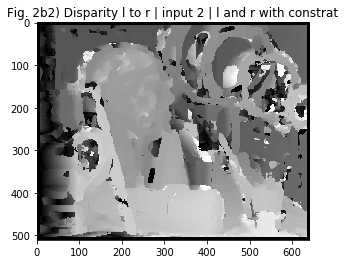

In [30]:
plt.imshow(np.absolute(D2_l_to_r_contrast_both), cmap = 'gray')
plt.title("Fig. 2b2) Disparity l to r | input 2 | l and r with constrat")
plt.show()

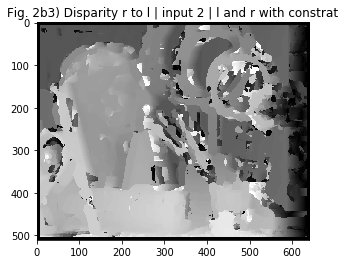

In [31]:
plt.imshow(np.absolute(D2_r_to_l_contrast_both), cmap = 'gray')
plt.title("Fig. 2b3) Disparity r to l | input 2 | l and r with constrat")
plt.show()

In [32]:
misc.imsave('./output/ps2-3-b-1.png', np.absolute(D2_l_to_r_contrast_both))
misc.imsave('./output/ps2-3-b-2.png', np.absolute(D2_r_to_l_contrast_both))

<u> Interpretation </u>

The SSD is sensitive to contrast because contrasting a picture emphasizes the intensity differences for a given factor (here 10%). Contrasting sharpens local pixels intensity. Hence the whole comparison metric used by SSD is affected. 

The key is to choose a factor that emphasizes the difference relatively: A too big factor could lead to a lack of accuracy in the template matching (too much pixels reach the maximum : differences in intensity vanished).
Here, 10 % seems a fair choice.

Note that both left and right should be contrasted with the same factor for a better template matching (Fig 2b2 and 2b3).

### 4. Normalized correlation

Normalized correlation is a different disparity metric. Now, we think of two image patches as vectors and we compute the angle between them ( simila to normalized dot products). Because of its normalization, this method is not sensitive to illumination (pixel intensity) comparing to the SSD.

Let see the robustness of the Normalized correlation method on non-perturbated and perturbated picture.

#### a. On original pictures

In [38]:
D31a_l_to_r = basic_stereo_algo(input21_left, 
                                input21_right, verbose = False,
                                l_to_r = True, norma_corr= True)

In [39]:
D31a_r_to_l = basic_stereo_algo(input21_right, 
                                input21_left, verbose = False, 
                                l_to_r = False, norma_corr= True)

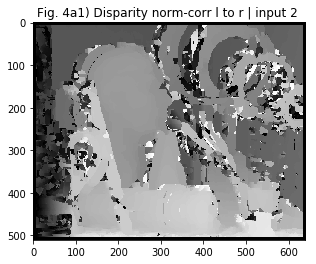

In [40]:
D31a_l_to_r = np.absolute(D31a_l_to_r)
plt.imshow(D31a_l_to_r, cmap= 'gray')
plt.title("Fig. 4a1) Disparity norm-corr l to r | input 2 ")
plt.show()

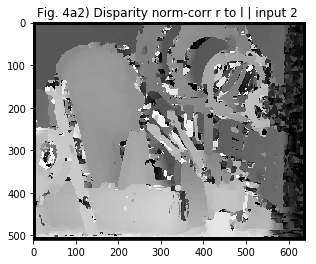

In [41]:
D31a_r_to_l = np.absolute(D31a_r_to_l)
plt.imshow(D31a_r_to_l, cmap= 'gray')
plt.title("Fig. 4a2) Disparity norm-corr r to l | input 2 ")
plt.show()

In [42]:
misc.imsave('./output/ps2-4-a-1.png', np.absolute(D31a_l_to_r))
misc.imsave('./output/ps2-4-a-2.png', np.absolute(D31a_r_to_l))

<u> Interpretation </u>

The disparity pictures are much closer to the ground truth thant those obtained with SSD. Indeed, the shifted objects have a consistant disparity within the entire shapes. The normalized correlation conserved a consistancy within the similar shape. Indeed similarly shaped windows of pixels (i.e with similar distribution of pixels intensity), will be detected and used during the computation of the angle between both windows. To match templates, the normalized correlation don't use  the raw sum of pixels intensity (like SSD method) but use instead the 'distribution' of the pixels intensity within the windows.

#### b. On Noised pictures

##### 1. Contrast

In [43]:
# Contrast ? Norm corr doesnt care about pixels intensity : doesnt change . contrast or not
D4_l_to_r_contrast_both = basic_stereo_algo(
    input21_left_contrast, input21_right_contrast, 
    verbose = False, l_to_r= True, norma_corr= True)

In [44]:
D4_r_to_l_contrast_both = basic_stereo_algo(
    input21_right_contrast, input21_left_contrast, 
    verbose = False, l_to_r= False, norma_corr= True)

In [45]:
D4_l_to_r_contrast = basic_stereo_algo(
    input21_left_contrast, input21_right, 
    verbose = False, l_to_r= True, norma_corr= True)

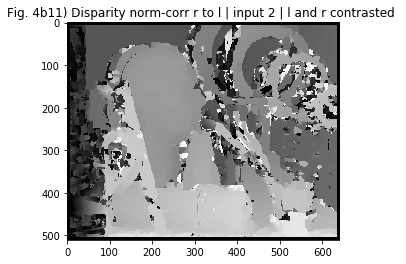

In [46]:
plt.imshow(np.absolute(D4_l_to_r_contrast_both), cmap= 'gray')
plt.title("Fig. 4b11) Disparity norm-corr r to l | input 2 | l and r contrasted ")
plt.show()

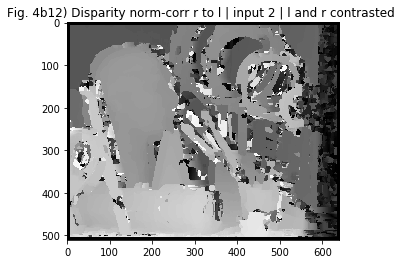

In [47]:
plt.imshow(np.absolute(D4_r_to_l_contrast_both), cmap= 'gray')
plt.title("Fig. 4b12) Disparity norm-corr r to l | input 2 | l and r contrasted ")
plt.show()

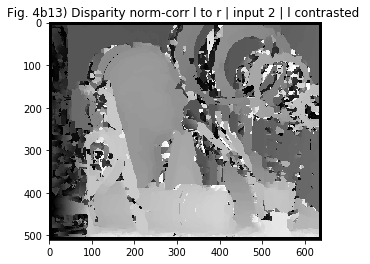

In [48]:
plt.imshow(np.absolute(D4_l_to_r_contrast), cmap= 'gray')
plt.title("Fig. 4b13) Disparity norm-corr l to r | input 2 | l contrasted ")
plt.show()

In [49]:
misc.imsave('./output/ps2-4-b-1.png', np.absolute(D4_l_to_r_contrast_both))
misc.imsave('./output/ps2-4-b-2.png', np.absolute(D4_r_to_l_contrast_both))

<u> Interpretation </u>

We can see that, regardless if we computed the disparity using contrasted picture (Fig 4b13), two contrasted pictures (Fig 4b11) or no contrasted pictures (Fig 4a1) : the disparity is the same.

Again, because this method normalizes the pixels intensity, it is more robust to variation of pixel intensity.

To sum up, normalized correlation is a more robust solution for template matching on pictures taken under different luminosities or sensors (which is usally the case in the real world).

##### 2. Gaussian

In [50]:
# Gaussian ? Norm corr is robust to gaussian noise ? 
D4_l_to_r_gaussian = basic_stereo_algo(
    gaussian_input21_L, gaussian_input21_R, 
    verbose = False, l_to_r= True, norma_corr= True)

In [51]:
D4_r_to_l_gaussian = basic_stereo_algo(
    gaussian_input21_R, gaussian_input21_L,
    verbose = False, l_to_r= False, norma_corr= True)

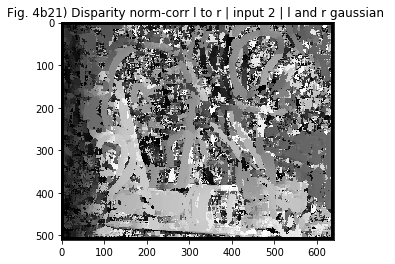

In [85]:
plt.imshow(np.absolute(D4_l_to_r_gaussian), cmap= 'gray')
plt.title("Fig. 4b21) Disparity norm-corr l to r | input 2 | l and r gaussian ")
plt.show()

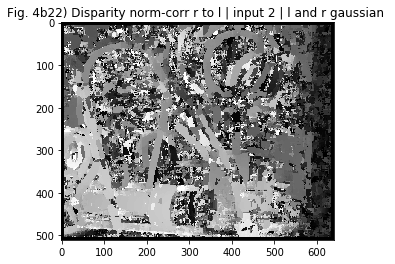

In [86]:
plt.imshow(np.absolute(D4_r_to_l_gaussian), cmap= 'gray')
plt.title("Fig. 4b22) Disparity norm-corr r to l | input 2 | l and r gaussian ")
plt.show()

In [53]:
misc.imsave('./output/ps2-4-b-3.png', np.absolute(D4_l_to_r_gaussian))
misc.imsave('./output/ps2-4-b-4.png', np.absolute(D4_r_to_l_gaussian))

<u> Interpretation </u>

Normalized correlation remains sensitive to gaussian noise. Fig 4b21 shows that for a sigma (in gaussian noise parameter) = 30, the disparity picture is bad and noisy (similar to the SSD method).

### 5. Second pair & solutions

In [54]:
input3_left = cv2.imread("data/proj2-pair2-L.png", 0)
input3_right = cv2.imread("data/proj2-pair2-R.png", 0)
ground_truth_3 = cv2.imread("data/proj2-pair2-Disp-L.png", 0)

#### a. Original

In [55]:
D5a_l_to_r = basic_stereo_algo(
    input3_left, input3_right,
    verbose = False, l_to_r= True, norma_corr= False)

D5a_nocorr_l_to_r = basic_stereo_algo(
    input3_left, input3_right,
    verbose = False, l_to_r= True, norma_corr= True)

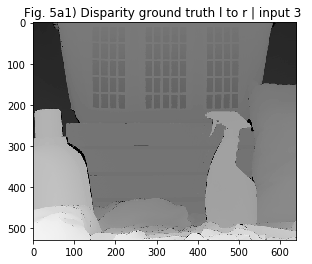

In [82]:
plt.imshow(np.absolute(ground_truth_3), cmap= 'gray')
plt.title("Fig. 5a1) Disparity ground truth l to r | input 3 ")
plt.show()

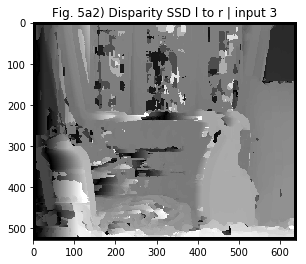

In [83]:
plt.imshow(np.absolute(D5a_l_to_r), cmap= 'gray')
plt.title("Fig. 5a2) Disparity SSD l to r | input 3")
plt.show()

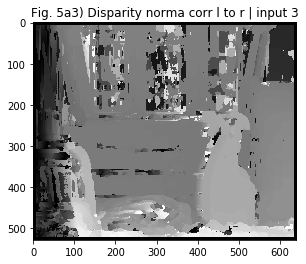

In [84]:
plt.imshow(np.absolute(D5a_nocorr_l_to_r), cmap = 'gray')
plt.title("Fig. 5a3) Disparity norma corr l to r | input 3")
plt.show()

In [57]:
misc.imsave('./output/ps2-5-a-1.png', np.absolute(D5a_l_to_r))
misc.imsave('./output/ps2-5-a-2.png', np.absolute(D5a_nocorr_l_to_r))

<u> Interpretation </u>

Again, our disparity pictures are both relatively correct regarding the ground truth : shapes are detected and disparity values remain globally constistent with the disparity proposed in the ground truth.

It is interesting to point out, that the windows background is considered as noisy in our disparity pictues. This makes sense since the pattern 'window' is repeated in this picture. Hence, the template matcher doesnt make a difference between the first window or any other in the picture.

Solutions could be :

Tune the template size parameter (window size) to assure a better template matching.

<u> Bigger window size on, norm corra</u>


In [58]:
D5a_nocorr_l_to_r_28 = basic_stereo_algo(
    input3_left, input3_right,
    verbose = False, l_to_r= True, norma_corr= True, window_size = 28)

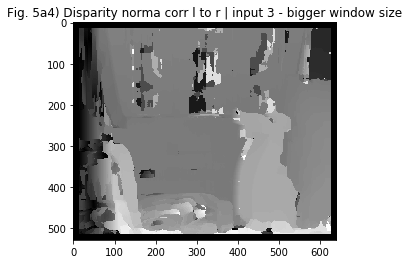

In [59]:
plt.imshow(np.absolute(D5a_nocorr_l_to_r_28), cmap = 'gray')
plt.title("Fig. 5a4) Disparity norma corr l to r | input 3 - bigger window size")
plt.show()

<u> Smaller window size on, norm corra</u>

In [60]:
D5a_nocorr_l_to_r_4 = basic_stereo_algo(
    input3_left, input3_right,
    verbose = False, l_to_r= True, norma_corr= True, window_size = 4)

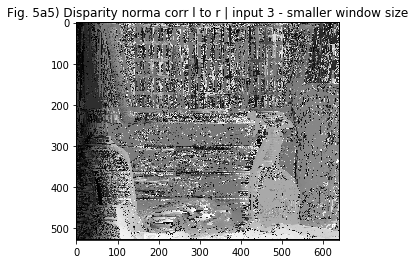

In [61]:
plt.imshow(np.absolute(D5a_nocorr_l_to_r_4), cmap = 'gray')
plt.title("Fig. 5a5) Disparity norma corr l to r | input 3 - smaller window size")
plt.show()

In [63]:
D5a_nocorr_l_to_r_4_smoo = ndimage.filters.median_filter(D5a_nocorr_l_to_r_4, size= 8)

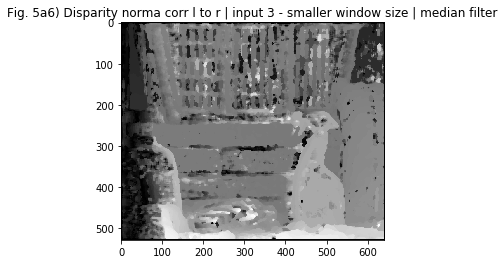

In [64]:
plt.imshow(np.absolute(D5a_nocorr_l_to_r_4_smoo), cmap = 'gray')
plt.title("Fig. 5a6) Disparity norma corr l to r | input 3 - smaller window size | median filter")
plt.show()

In [65]:
misc.imsave('./output/ps2-5-a-3.png', np.absolute(D5a_nocorr_l_to_r_28))
misc.imsave('./output/ps2-5-a-4.png', np.absolute(D5a_nocorr_l_to_r_4_smoo))

<u> Interpreation </u>

A smaller window size parameter provides a better accuracy of the disparity values (fig 5a6). However, the window patterns are still hard to match with the correct one. Again, some high values in the disparity picture (Fig 5a6) at the windows positions, show that the template matcher used to match a window pattern from one picture, with an other similar but not corresponding, on the other picture.

Note that we applied a median filter in the disparity picture 5a6, to smooth the noise obtained due to the very small window_size parameter choosen (here = 4).

#### b. Gaussian smoothed

In [66]:
input3_left_smoo = ndimage.filters.gaussian_filter(input3_left, sigma=3)
input3_right_smoo = ndimage.filters.gaussian_filter(input3_right, sigma=3)

In [67]:
D5b_l_to_r_gauss = basic_stereo_algo(
    input3_left_smoo, input3_right_smoo,
    verbose = False, l_to_r= True, norma_corr= False)

D5b_nocorr_l_to_r_gauss = basic_stereo_algo(
    input3_left_smoo, input3_right_smoo,
    verbose = False, l_to_r= True, norma_corr= True)

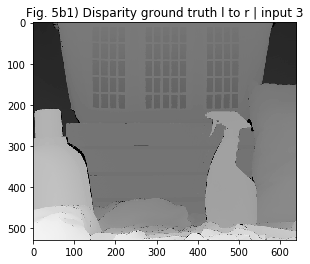

In [79]:
plt.imshow(np.absolute(ground_truth_3), cmap= 'gray')
plt.title("Fig. 5b1) Disparity ground truth l to r | input 3")
plt.show()

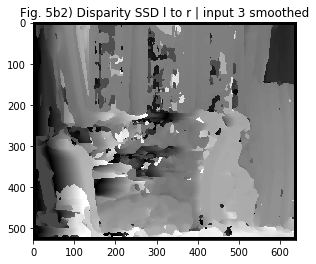

In [80]:
plt.imshow(np.absolute(D5b_l_to_r_gauss), cmap= 'gray')
plt.title("Fig. 5b2) Disparity SSD l to r | input 3 smoothed")
plt.show()

plt.imshow(np.absolute(D5b_nocorr_l_to_r_gauss), cmap = 'gray')
plt.title("Fig. 5b3) Disparity norma corr l to r | input 3 smoothed")
plt.show()

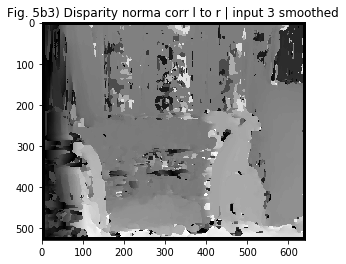

In [81]:
plt.imshow(np.absolute(D5b_nocorr_l_to_r_gauss), cmap = 'gray')
plt.title("Fig. 5b3) Disparity norma corr l to r | input 3 smoothed")
plt.show()

In [69]:
misc.imsave('./output/ps2-5-b-1.png', np.absolute(D5b_l_to_r_gauss))
misc.imsave('./output/ps2-5-b-2.png', np.absolute(D5b_nocorr_l_to_r_gauss))

<u> Interpretation </u>

We can notice that applying a gaussian smoother, doesn't provide a better disparity picture in both SSD and norm corr method.

Indeed, the gaussian smoother will tend to 'smooth' the pixel intensities which could be useful in case of a noisy picture, but not really in the case of this picture. For this picture, a more appropriate method would be to sharpen the local pixel intensities instead of smoothing them (at least for the SSD method). This will be the case for the contrast.


The only 'advantage' here could be that, comparing to the original picture, the disparity is a bit less noisy on the window patterns for a template size = 16.

#### c. Contrast Boost

In [70]:
input3_left_cont = change_contrast(input3_left, 1.1)
input3_right_cont = change_contrast(input3_right, 1.1)

In [71]:
D5c_l_to_r = basic_stereo_algo(
    input3_left_cont, input3_right_cont,
    verbose = False, l_to_r= True, norma_corr= False)

D5c_nocorr_l_to_r = basic_stereo_algo(
    input3_left_cont, input3_right_cont,
    verbose = False, l_to_r= True, norma_corr= True)

In [72]:
D5c_l_to_r_small_window = basic_stereo_algo(
    input3_left_cont, input3_right_cont,
    verbose = False, l_to_r= True, norma_corr= False, window_size = 4)

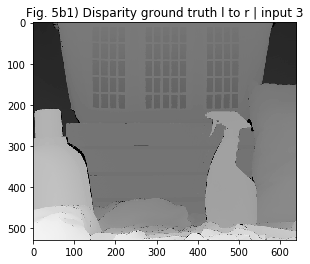

In [75]:
plt.imshow(np.absolute(ground_truth_3), cmap= 'gray')
plt.title("Fig. 5b1) Disparity ground truth l to r | input 3")
plt.show()

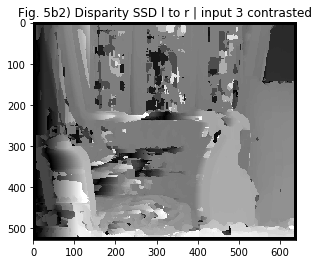

In [76]:
plt.imshow(np.absolute(D5c_l_to_r), cmap= 'gray')
plt.title("Fig. 5b2) Disparity SSD l to r | input 3 contrasted")
plt.show()

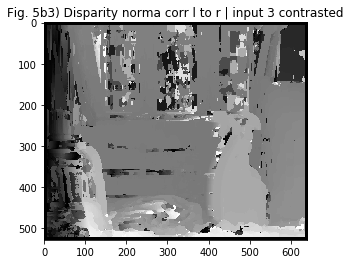

In [77]:
plt.imshow(np.absolute(D5c_nocorr_l_to_r), cmap = 'gray')
plt.title("Fig. 5b3) Disparity norma corr l to r | input 3 contrasted")
plt.show()

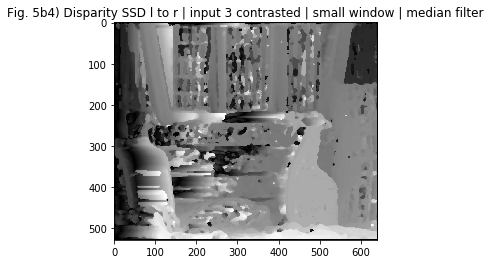

In [78]:
plt.imshow(np.absolute(ndimage.filters.median_filter(D5c_l_to_r_small_window, size= 8)), cmap= 'gray')
plt.title("Fig. 5b4) Disparity SSD l to r | input 3 contrasted | small window | median filter")
plt.show()

In [74]:
misc.imsave('./output/ps2-5-c-1.png', np.absolute(D5c_l_to_r))
misc.imsave('./output/ps2-5-c-2.png', np.absolute(D5c_nocorr_l_to_r))
misc.imsave('./output/ps2-5-c-3.png', np.absolute(
    ndimage.filters.median_filter(D5c_l_to_r_small_window, size= 8)))

<u> Conclusion </u>

To sum up, this assignments gave us some clues on what to consider when applying a stereo window based approach.

A first important parameter is to set an appropriate min and max offset, regarding the shift between the shapes in the pictures. Find a great trade-off between accuracy loss and informations required.

Second, the window-size can drastically change the output disparity pictures. The window size has to be adapted to the size of the smallest and biggest patterns in the picture (ex : for detecting little-windows pattern in the last pair of pictures). It also as to consider the size of texture-less portions on pictures, where matching template are difficult.
Nevertheless a very small window size could lead to salt&pepper-like noise in the disparity picture, but a median filter can then help reducing this noise.

Regarding the similarity/disparity metric used, the SSD method is computationally faster but remains very sensible to variation in luminosity. For this reason, a contrast noise applied one of the two pictures will reduce the accuracy of the template matcher using SSD. However, since contrasting sharpen the local pixel intensities, having both picture contrasted at an appropriate factor would help the ssd template matcher.

The normalized correlation doesn't consider the pixel intensities to match similar window but rather consider each window as a flattened vector and compute the angle between them. This makes the normalized correlation very robust to variation in luminosity (contrast noise or real case picture taken at different level of  luminosities due to the sun occlusion or hour of the day for example.).

Finally, both SSD and normalized correlation were not producing great result on gaussian noised. This is due to the fact that gaussian noise, not only change the overall pixels intensities in a window (affect ssd) but also add a random caracteristic to each pixel value (affect normalized correlation).